# Circular 2D crystal with strain
This notebook computes the scattering from a circular crystal with a strain gradient from the center of the circle :
$$ I(H,K) = \left | \sum_{n=0}^{N-1} \sum_{n=0}^{N-1} \Omega \left (n,m \right ) \exp \left \{ 2 \pi i \left [ H \left (n + \Delta n\right )+ K \left (m + \Delta m\right ) \right ] \right \} \right | ^2$$
$\Omega$ is the support function (1 inside the crystal, 0 outside). $\Delta n$ and $\Delta m$ are unit-cell displacements along each axis of the crystal. 

First we load the external libraries.

In [1]:
import os
import math
import cmath
import numpy as np
import numba as nb
import numexpr as ne
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
n_cpu = os.cpu_count()

Then we define the size of the crystal (N) and the HK reflection to be computed. A complete reciprocal space unit-cell is rendered with a resolution defined by the sampling rate. For this particular example we use a radial lattice variation from the center of the particle.


In [2]:
H = 0 #Miller index of reflection
K = 4 #Miller index of reflection
N = 100 #Number of units cells per direction
oversampling = 6 #Defines how much points are needed to describe a single Laue fringe (2 = Nyquist frequency)
e0 = 0.01 #Maximum strain at surface
w = 20. #Width of the strain profile below the surface
#Generate real and reciprocal space coordinates
n = np.arange(N)
m = np.arange(N)
h = np.arange(H-0.5, H+0.5, 1./(oversampling*N))
k = np.arange(K-0.5, K+0.5, 1./(oversampling*N))

## Pure python implementation

In [3]:
def Circ_python(n, m, h, k, e0, w):
    result = [[0 for x in range(len(h))] for y in range(len(k))]
    N = len(n)
    for i_h, v_h in enumerate(h): #loop over the reciprocal space coordinates
        for i_k, v_k in enumerate(k):
            tmp = 0.0
            for i_n in n:#loop and sum over unit-cells
                for i_m in m:
                    radius = math.sqrt((i_n - N/2)** 2 + (i_m - N/2)** 2)
                    if radius <= (N/2):
                        strain = e0 * (1 + math.tanh((radius-N/2)/w))
                        tmp += cmath.exp(2j*cmath.pi*(v_h*(i_n+strain*(i_n-N/2)) + v_k*(i_m+strain*(i_m-N/2))))
            result[i_h][i_k] = abs(tmp)**2
    return np.array(result)

%time ref_intensity = Circ_python(n, m, h, k, e0, w)

CPU times: user 8h 58min 26s, sys: 10.3 s, total: 8h 58min 36s
Wall time: 8h 58min 36s


<IPython.core.display.Javascript object>


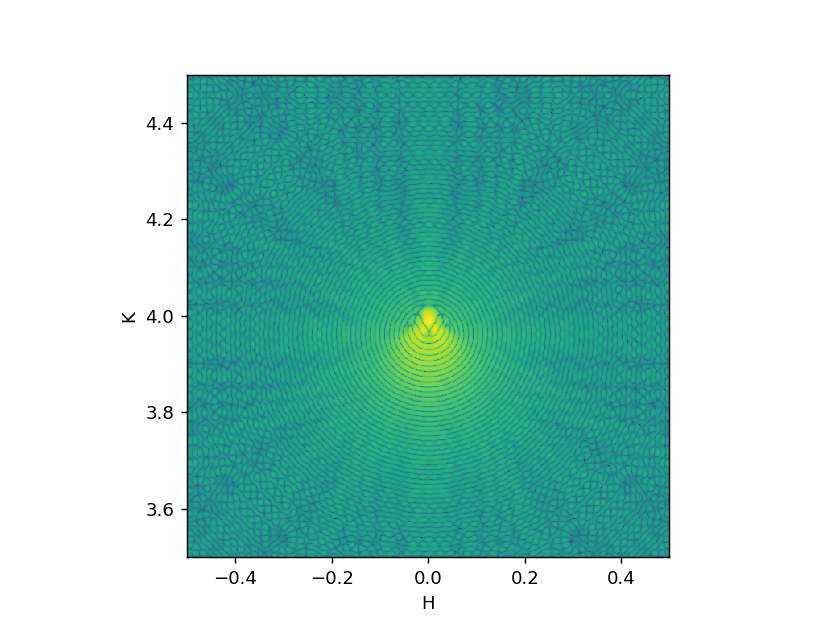

In [4]:
%matplotlib notebook
plt.figure(1)
plt.imshow(ref_intensity.T, extent=(h.min(), h.max(), k.min(), k.max()), norm=LogNorm(), origin = 'lower')
plt.xlabel('H')
plt.ylabel('K')
plt.show()

## Pure Numpy implementation

In [5]:
def Circ_numpy(n, m, h, k, e0, w):
    N = len(n)
    h = h[:, np.newaxis, np.newaxis, np.newaxis]
    k = k[np.newaxis, :, np.newaxis, np.newaxis]
    n = n[np.newaxis, np.newaxis, :, np.newaxis]
    m = m[np.newaxis, np.newaxis, np.newaxis, :]
    radius = np.sqrt((n - N/2)**2 + (m - N/2)**2)
    support = np.where(radius > N/2, 0, 1)
    strain = e0 * (1 + np.tanh((radius-N/2) / w))
    tmp = (support * np.exp(2j*np.pi*(h*(n+strain*(n-N/2)) + k*(m+strain*(m-N/2)))))
    return np.abs(tmp.sum(axis=(2,3)))**2

%time intensity = Circ_numpy(n, m, h, k, e0, w)
%timeit Circ_numpy(n, m, h, k, e0, w)
print("Error:", abs(intensity-ref_intensity).max())

CPU times: user 3min 15s, sys: 1min 21s, total: 4min 36s
Wall time: 4min 36s
1 loop, best of 3: 5min 9s per loop
Error: 1.39698386192e-07


## Numpy + for loop

In [6]:
def Circ_numpy_hybrid(n, m, h, k, e0, w):
    result = np.zeros((h.size, k.size))
    N = len(n)
    n=n[:,np.newaxis]
    m=m[np.newaxis,:]
    n_c = (n - N/2)
    m_c = (m - N/2)
    radius = np.sqrt(n_c**2 + m_c**2)
    strain = e0 * (1 + np.tanh((radius-N/2) / w))
    support = np.where(radius > N/2, 0, 1)
    
    n_s = n + strain * n_c
    m_s = m + strain * m_c
    #loop over the reciprocal space coordinates
    for i_h, v_h in enumerate(h):
        for i_k, v_k in enumerate(k): 
            tmp = (support * np.exp(2j*np.pi*(v_h*n_s + v_k*m_s))).sum()
            result[i_h, i_k] = abs(tmp)**2
    return result

%time intensity = Circ_numpy_hybrid(n, m, h, k, e0, w)
%timeit Circ_numpy_hybrid(n, m, h, k, e0, w)
print("Error:", abs(intensity-ref_intensity).max())

CPU times: user 3min 7s, sys: 7.96 ms, total: 3min 7s
Wall time: 3min 7s
1 loop, best of 3: 3min 5s per loop
Error: 1.39698386192e-07


## NumExpr implementation

In [7]:
def Circ_numexpr(n, m, h, k, e0, w):
    N = len(n)
    h = h[:, np.newaxis, np.newaxis, np.newaxis]
    k = k[np.newaxis, :, np.newaxis, np.newaxis]
    n = n[np.newaxis, np.newaxis, :, np.newaxis]
    m = m[np.newaxis, np.newaxis, np.newaxis, :]
    ne.set_num_threads(1)
    radius = ne.evaluate("sqrt((n - N/2)**2 + (m - N/2)**2)")
    strain = ne.evaluate("e0 * (1 + tanh((radius-N/2) / w))")
    j2pi = np.pi*2j
    tmp = ne.evaluate("where(radius > N/2, 0, exp(j2pi*(h*(n+strain*(n-N/2)) + k*(m+strain*(m-N/2)))))")
    tmp.shape = k.size, h.size, -1
    result = abs(tmp.sum(axis=-1))**2
    return result

%time  intensity = Circ_numexpr(n, m, h, k, e0, w)
%timeit Circ_numexpr(n, m, h, k, e0, w)
print("Error:", abs(intensity-ref_intensity).max())

CPU times: user 3min 32s, sys: 22.8 s, total: 3min 55s
Wall time: 3min 55s
1 loop, best of 3: 3min 48s per loop
Error: 1.39698386192e-07


In [8]:
def Circ_numexpr_hybrid(n, m, h, k, e0, w):
    result = np.zeros((h.size, k.size))
    N = len(n)
    n=np.atleast_2d(n).T
    m=np.atleast_2d(m)
    n_c = (n - N/2)
    m_c = (m - N/2)
    radius = np.sqrt(n_c**2 + m_c**2)
    strain = e0 * (1 + np.tanh((radius-N/2) / w))
    support = np.where(radius > N/2, 0, 1)
    j2pi = np.pi*2j
    n_s = n + strain * (n_c)
    m_s = m + strain * (m_c)
    #loop over the reciprocal space coordinates
    for i_h, v_h in enumerate(h): 
        for i_k, v_k in enumerate(k):
            tmp = ne.evaluate("where(radius > N/2, 0, exp(j2pi*(v_h*n_s + v_k*m_s)))").sum()
            result[i_h, i_k] = tmp.real*tmp.real + tmp.imag*tmp.imag
    return result

%time intensity = Circ_numexpr_hybrid(n, m, h, k, e0, w)
%timeit Circ_numexpr_hybrid(n, m, h, k, e0, w)
print("Error:", abs(intensity-ref_intensity).max())

CPU times: user 3min 9s, sys: 89 µs, total: 3min 9s
Wall time: 3min 9s
1 loop, best of 3: 3min 3s per loop
Error: 1.39698386192e-07


## NumExpr (multi-threaded) implementation

In [9]:
def Circ_numexpr_parallel(n, m, h, k, e0, w):
    N = len(n)
    h = h[:, np.newaxis, np.newaxis, np.newaxis]
    k = k[np.newaxis, :, np.newaxis, np.newaxis]
    n = n[np.newaxis, np.newaxis, :, np.newaxis]
    m = m[np.newaxis, np.newaxis, np.newaxis, :]
    ne.set_num_threads(n_cpu)
    radius = ne.evaluate("sqrt((n - N/2)**2 + (m - N/2)**2)")
    strain = ne.evaluate("e0 * (1 + tanh((radius-N/2) / w))")
    j2pi = np.pi*2j
    #loop over the reciprocal space coordinates
    tmp = ne.evaluate("where(radius > N/2, 0, exp(j2pi*(h*(n+strain*(n-N/2)) + k*(m+strain*(m-N/2)))))")
    tmp.shape = k.size, h.size, -1
    result = abs(tmp.sum(axis=-1))**2
    return result

%time  intensity = Circ_numexpr_parallel(n, m, h, k, e0, w)
%timeit Circ_numexpr_parallel(n, m, h, k, e0, w)
print("Error:", abs(intensity-ref_intensity).max())

CPU times: user 8min 4s, sys: 42.5 s, total: 8min 47s
Wall time: 21.7 s
1 loop, best of 3: 26.5 s per loop
Error: 1.39698386192e-07


## Numba (single thread) implementation

In [10]:
@nb.jit(nb.float64[:,:](nb.int64[:],nb.int64[:],nb.float64[:],nb.float64[:],nb.float64, nb.float64), 
        nopython=True)
def Circ_numba(n, m, h, k, e0, w):
    result = np.zeros(len(h)*len(k), dtype=nb.float64)
    N = len(n)
    for i in range(len(h)*len(k)): #loop over the reciprocal space coordinates
        tmp = 0j
        for i_n in n:#loop and sum over unit-cells
            for i_m in m:
                radius = math.sqrt((i_n - N/2)** 2 + (i_m - N/2)** 2)
                if radius <= (N/2):
                    strain = e0 * (1 + math.tanh((radius-N/2)/w))
                    tmp +=  cmath.exp(2j*cmath.pi*(h[i//len(h)]*(i_n+strain*(i_n-N/2)) + k[i%len(h)]*(i_m+strain*(i_m-N/2)))) #cmath library works better with numba than numpy math
        result[i] = abs(tmp)**2
    return result.reshape(len(h),len(k))

%time intensity = Circ_numba(n, m, h, k, e0, w)
%timeit Circ_numba(n, m, h, k, e0, w)
print("Error:", abs(intensity-ref_intensity).max())

CPU times: user 4min 57s, sys: 584 ms, total: 4min 58s
Wall time: 4min 57s
1 loop, best of 3: 4min 51s per loop
Error: 0.0


## Numba (multi-threaded / parallel) implementation

In [11]:
@nb.jit(nb.float64[:,:](nb.int64[:],nb.int64[:],nb.float64[:],nb.float64[:],nb.float64, nb.float64), 
        nopython=True, parallel=True, fastmath=True)
def Circ_numba_parallel(n, m, h, k, e0, w):
    result = np.zeros(len(h)*len(k), dtype=nb.float64)
    N = len(n)
    for i in nb.prange(len(h)*len(k)): #loop over the reciprocal space coordinates
        tmp = 0j
        for i_n in n:#loop and sum over unit-cells
            for i_m in m:
                support = 1.0
                radius = math.sqrt((i_n - N/2)** 2 + (i_m - N/2)** 2)
                if (radius > (N/2.)):
                    support = 0.0
                    #continue #Numba isn't working using the same continue pattern as below
                strain = e0 * (1 + math.tanh((radius-N/2)/w))
                tmp +=  support * cmath.exp(2j*cmath.pi*(h[i//len(h)]*(i_n+strain*(i_n-N/2)) + k[i%len(h)]*(i_m+strain*(i_m-N/2)))) #cmath library works better with numba than numpy math
        result[i] = abs(tmp)**2
    return result.reshape((len(h),len(k)))

%time intensity = Circ_numba_parallel(n, m, h, k, e0, w)
%timeit Circ_numba_parallel(n, m, h, k, e0, w)
print("Error:", abs(intensity-ref_intensity).max())

CPU times: user 9min 58s, sys: 0 ns, total: 9min 58s
Wall time: 7.74 s
1 loop, best of 3: 7.74 s per loop
Error: 0.0


## Pythran (single thread) implementation

In [12]:
%load_ext pythran.magic

In [13]:
%%pythran -fopenmp

#pythran export Circ_pythran(int[] or float[], int[] or float[], float[], float[], float, float or int)
import numpy as np

def Circ_pythran(n, m, h, k, e0, w):
    result = np.zeros((len(k),len(h)), dtype=np.float64)
    N = len(n)
    #"omp parallel for"
    for i_h, v_h in enumerate(h): #loop over the reciprocal space coordinates
        for i_k, v_k in enumerate(k):
            tmp = 0j
            for i_n in n:
                for i_m in m:
                    radius = np.sqrt((i_n - N/2.)** 2 + (i_m - N/2.)** 2)
                    if (radius > (N/2.)):
                        continue
                    strain = e0 * (1 + np.tanh((radius-N/2.)/w))
                    tmp += np.exp(2j*np.pi*(v_h*(i_n+strain*(i_n-N/2.)) + v_k*(i_m+strain*(i_m-N/2.))))
            result[i_h, i_k] = abs(tmp)**2
    return result

In [14]:
%time intensity = Circ_pythran(n, m, h, k, e0, w)
%timeit Circ_pythran(n, m, h, k, e0, w)
print("Error:", abs(intensity-ref_intensity).max())

CPU times: user 4min 29s, sys: 4.13 ms, total: 4min 29s
Wall time: 4min 29s
1 loop, best of 3: 4min 29s per loop
Error: 3.72529029846e-09


## Pythran multi-threaded implementation

In [15]:
%%pythran -fopenmp

#pythran export Circ_pythran_parallel(int[] or float[], int[] or float[], float[], float[], float, float or int)
import numpy as np

def Circ_pythran_parallel(n, m, h, k, e0, w):
    result = np.zeros((len(k),len(h)), dtype=np.float64)
    N = len(n)
    "omp parallel for"
    for i_h, v_h in enumerate(h): #loop over the reciprocal space coordinates
        for i_k, v_k in enumerate(k):
            tmp = 0j
            for i_n in n:
                for i_m in m:
                    radius = np.sqrt((i_n - N/2.)** 2 + (i_m - N/2.)** 2)
                    if (radius > (N/2.)):
                        continue
                    strain = e0 * (1 + np.tanh((radius-N/2.)/w))
                    tmp += np.exp(2j*np.pi*(v_h*(i_n+strain*(i_n-N/2.)) + v_k*(i_m+strain*(i_m-N/2.))))
            result[i_h, i_k] = abs(tmp)**2
    return result

In [16]:
%time intensity = Circ_pythran_parallel(n, m, h, k, e0, w)
%timeit Circ_pythran_parallel(n, m, h, k, e0, w)
print("Error:", abs(intensity-ref_intensity).max())

CPU times: user 7min 50s, sys: 52.8 ms, total: 7min 50s
Wall time: 6.47 s
1 loop, best of 3: 6.32 s per loop
Error: 3.72529029846e-09


## Cython (single thread) implementation

In [17]:
%load_ext Cython

In [18]:
%%cython -a --compile-args=-fopenmp --link-args=-fopenmp
import numpy as np
from cython.parallel import prange
import cython

from libc.math cimport sqrt, tanh

cdef extern from "complex.h" nogil:
    double complex cexp(double complex)
    double cabs(double complex)
    
@cython.wraparound(False)
@cython.boundscheck(False)
@cython.cdivision(True)
def Circ_cython(long[::1] n, long[::1] m, double[::1] h, 
                double[::1] k, double e0, int w):
    cdef:
        double[:, ::1] result
        double v_h, v_k, radius, strain
        double complex tmp, two_j_pi
        int i_h, i_k, i_m, i_n, size_h, size_k, N
        
    two_j_pi = np.pi*2j
    size_h = h.size
    size_k = k.size
    N = n.size
    result = np.zeros((size_k, size_h))
    #loop over the reciprocal space coordinates
    for i_k in range(size_k):
        v_k = k[i_k]
        for i_h in range(size_h): 
            v_h = h[i_h]
            tmp = 0
            #loop and sum over unit-cells
            for i_n in range(N):
                for i_m in range(N):
                    radius = sqrt((i_n - N/2.)** 2 + (i_m - N/2.)** 2)
                    if (radius > (N/2.)):
                        continue
                    strain = e0 * (1 + tanh((radius-N/2.)/w))
                    tmp = tmp + cexp(two_j_pi*(v_h*(i_n+strain*(i_n-N/2.)) + v_k*(i_m+strain*(i_m-N/2.))))
            result[i_h, i_k] += cabs(tmp)**2

    return result


In [19]:
%time intensity = Circ_cython(n, m, h, k, e0, w)
%timeit Circ_cython(n, m, h, k, e0, w)
print("Error:", abs(intensity-ref_intensity).max())

CPU times: user 4min 43s, sys: 1.44 s, total: 4min 44s
Wall time: 4min 42s
1 loop, best of 3: 4min 35s per loop
Error: 0.0


## Cython (multi-threaded) implementation

In [20]:
%%cython -a --compile-args=-fopenmp --link-args=-fopenmp
import numpy as np
from cython.parallel import prange
import cython

from libc.math cimport sqrt, tanh

cdef extern from "complex.h" nogil:
    double complex cexp(double complex)
    double cabs(double complex)
      
@cython.wraparound(False)
@cython.boundscheck(False)
@cython.cdivision(True)
def Circ_cython_parallel(long[::1] n, 
                long[::1] m, 
                double[::1] h, 
                double[::1] k,
                double e0,
                int w):
    cdef:
        double[:, ::1] result
        double r_part, i_part, v_h, v_k, radius, strain
        double complex tmp, two_j_pi
        int i_h, i_k, i_m, i_n, size_h, size_k, N
        
    two_j_pi = np.pi*2j
    size_h = h.size
    size_k = k.size
    N = n.size
    result = np.zeros((size_k, size_h))
    #loop over the reciprocal space coordinates
    for i_k in prange(size_k, nogil=True):
        v_k = k[i_k]
        for i_h in range(size_h): 
            v_h = h[i_h]
            tmp = 0
            #loop and sum over unit-cells
            for i_n in range(N):
                for i_m in range(N):
                    radius = sqrt((i_n - N/2.)** 2 + (i_m - N/2.)** 2)
                    if (radius > (N/2.)):
                        continue
                    strain = e0 * (1 + tanh((radius-N/2.)/w))
                    tmp = tmp + cexp(two_j_pi*(v_h*(i_n+strain*(i_n-N/2.)) + v_k*(i_m+strain*(i_m-N/2.))))
            result[i_h, i_k] += cabs(tmp)**2

    return result


In [21]:
%time intensity = Circ_cython_parallel(n, m, h, k, e0, w)
%timeit Circ_cython_parallel(n, m, h, k, e0, w)
print("Error:", abs(intensity-ref_intensity).max())

CPU times: user 8min 4s, sys: 32.5 ms, total: 8min 4s
Wall time: 6.69 s
1 loop, best of 3: 6.57 s per loop
Error: 0.0


## Fast Fourier Transform 

In [22]:
def Circ_fft(N, e0, w):
    n = np.arange(N*oversampling)[:,np.newaxis]
    m = np.arange(N*oversampling)[np.newaxis,:]
    radius = np.sqrt((n - N/2)** 2 + (m - N/2)** 2) # Compute the distance from center of crystal
    support = np.where(radius>N/2, 0, 1) # Set distances > threshold to 0
    strain = e0 * (1 + np.tanh((radius-N/2)/w))
    return np.fft.fftshift(abs(np.fft.fft2(support*np.exp(-2j*np.pi*(H*strain*(n-N/2) + K*strain*(m-N/2)))))**2)

%time intensity = Circ_fft(N, e0, w)
%timeit Circ_fft(N, e0, w)
print("Error:", abs(intensity-ref_intensity).max())

CPU times: user 47.3 ms, sys: 11.8 ms, total: 59.2 ms
Wall time: 58 ms
10 loops, best of 3: 44.8 ms per loop
Error: 161538.114096
